In [19]:
import sys
import os
sys.path.append('../') # Add the root directory to sys.path

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm
from models.cvt import ConvolutionalVisionTransformer
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [21]:
data_dir = '../data/massive_stars.parquet'

In [22]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,466475508969557888,18411.494141,3.5385,-0.3139,B,M,"[1.4043112e-15, 1.3886055e-15, 1.3119094e-15, ..."
1,3325513363920961408,16151.836914,3.7164,0.0395,B,M,"[1.4678052e-15, 1.3982165e-15, 1.3334084e-15, ..."
2,3375508943611375488,18823.841797,3.4316,0.2918,B,M,"[1.0764202e-15, 1.0605224e-15, 1.0162869e-15, ..."
3,4063973032805550592,15295.044922,3.4026,0.0999,G,M,"[9.53517e-16, 9.214246e-16, 8.3622285e-16, 7.9..."
4,454379128715344896,13149.229492,3.8305,-0.9505,B,LM,"[6.8294334e-16, 6.693247e-16, 6.1780524e-16, 5..."


In [23]:
df = data.drop(columns = ['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,466475508969557888,M,"[1.4043112e-15, 1.3886055e-15, 1.3119094e-15, ..."
1,3325513363920961408,M,"[1.4678052e-15, 1.3982165e-15, 1.3334084e-15, ..."
2,3375508943611375488,M,"[1.0764202e-15, 1.0605224e-15, 1.0162869e-15, ..."
3,4063973032805550592,M,"[9.53517e-16, 9.214246e-16, 8.3622285e-16, 7.9..."
4,454379128715344896,LM,"[6.8294334e-16, 6.693247e-16, 6.1780524e-16, 5..."


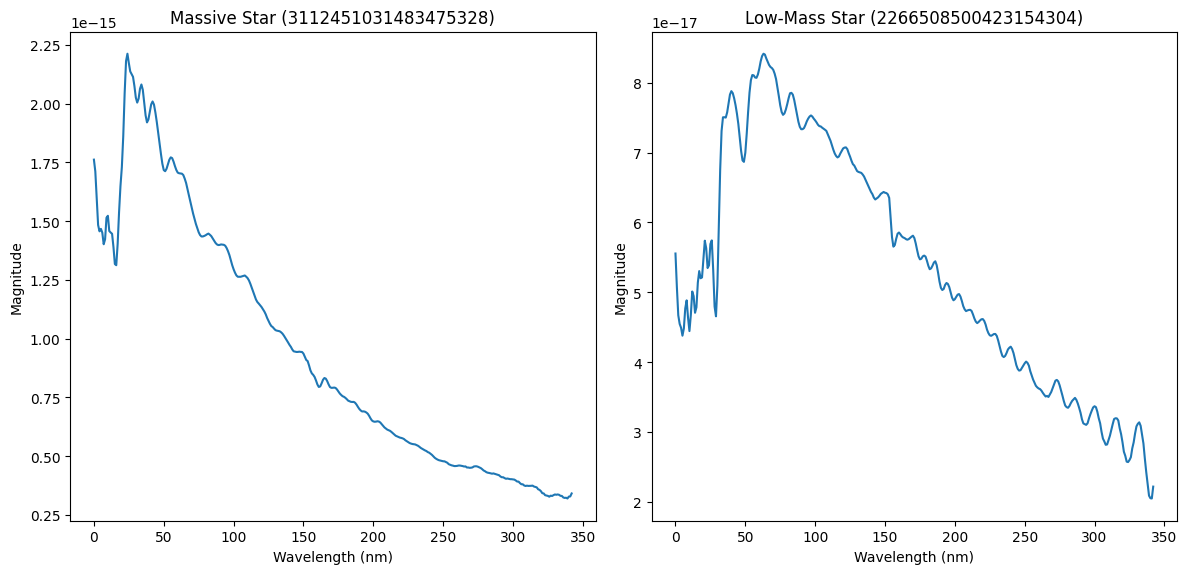

In [24]:
# execute this cell to see random examples of the difference in spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Ranomd sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(12, 6))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [25]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 17627
Number of bins in each spectra: 343
In the dataset, we have 11026 spectra for low mass stars and 6601 spectra for high mass stars.


In [26]:
X = np.vstack(df['flux'])
y = np.vstack(df['Cat'])

y = np.where(y == 'M', 1, y)
y = np.where(y == 'LM', 0, y)

y = y.astype(int)

In [27]:
split = 0.8

train_size = int(split * num_samples)

x_train, x_test = np.split(X, [train_size])
y_train, y_test = np.split(y, [train_size])

In [28]:
print("The dataset is divided into", len(x_train), "training samples and", len(x_test),"testing samples.")

The dataset is divided into 14101 training samples and 3526 testing samples.


In [29]:
spec = {}
spec['INIT'] = 'trunc_norm'
spec['NUM_STAGES'] = 3
spec['PATCH_SIZE'] = [7, 3, 3]
spec['PATCH_STRIDE'] = [4, 2, 2]
spec['PATCH_PADDING'] = [2, 1, 1]
spec['DIM_EMBED'] = [64, 192, 384]
spec['NUM_HEADS'] = [1, 3, 6]
spec['DEPTH'] = [1, 2, 10] 
spec['MLP_RATIO'] = [4.0, 4.0, 4.0]
spec['ATTN_DROP_RATE'] = [0.0, 0.0, 0.0]
spec['DROP_RATE'] = [0.0, 0.0, 0.0]
spec['DROP_PATH_RATE'] = [0.0, 0.0, 0.1]
spec['QKV_BIAS'] = [True, True, True]
spec['CLS_TOKEN'] = [False, False, True]
spec['POS_EMBED'] = [False, False, False]
spec['QKV_PROJ_METHOD'] = ['dw_bn', 'dw_bn', 'dw_bn']
spec['KERNEL_QKV'] = [3, 3, 3]
spec['PADDING_KV'] = [1, 1, 1]
spec['STRIDE_KV'] = [2, 2, 2]
spec['PADDING_Q'] = [1, 1, 1]
spec['STRIDE_Q'] = [1, 1, 1]

In [30]:
model = ConvolutionalVisionTransformer(in_chans= 343, num_classes=num_classes, spec=spec)

In [31]:
epochs = 10
device = 'cuda'
learning_rate = 1e-4
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
train_dataset = TensorDataset(torch.from_numpy(x_train).float(),
                              torch.from_numpy(y_train).float())
test_dataset = TensorDataset(torch.from_numpy(x_test).float(),
                              torch.from_numpy(y_test).float())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True)

In [ ]:
model.to(device)
print_freq = 50
for epoch in range(epochs):
    total, correct, cnt = 0, 0, 0
    for batch_id, (images, labels) in enumerate(train_loader, start=1):
        # images: tensor: [batch_size, 3, 224, 224]
        # labels: tensor: [batch_size]

        images = images.to(device)
        labels = labels.to(device)

        output = model(images)  # [batch_size, num_classes(5)]

        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = output.max(1)  # pred: [batch_size]

        total += len(labels)
        correct += sum(pred.detach().cpu() == labels.detach().cpu())

        accuracy = correct / total
        

        cnt += 1
        if cnt % print_freq == 0:
            print(f'epoch[{epoch}/{epochs}  {batch_id}/{len(train_loader.dataset)//batch_size}]  '
                    f'loss: {loss.item():.3f}  accuracy: {accuracy:.3f} ' )

        

    with torch.no_grad():
        total, correct, cnt = 0, 0, 0
        for batch_id, (images, labels) in enumerate(test_loader, start=1):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)

            _, pred = output.max(1)  # pred: [batch_size]

            total += len(labels)
            correct += sum(pred.detach().cpu() == labels.detach().cpu())

            accuracy = correct / total

            cnt += 1
            if cnt % print_freq == 0:
                print(f'valid {batch_id}/{len(test_loader.dataset)//batch_size}  '
                        f'loss: {loss.item():.3f}  accuracy: {accuracy:.3f} ')
